In [457]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import csv
import datetime
import gsw
import glob
import matplotlib as mpl
from matplotlib import colors
import matplotlib.cm as cm
#import matplotlib.colormaps as cmaps
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mpl_toolkits.axes_grid1.inset_locator as inset_axes
from netCDF4 import Dataset
import netCDF4 as nc
import numpy.ma as ma
import numpy as np
from numpy import linspace
import os
import pandas as pd
import pickle
#import rasterio.plot
import scipy.io
from scipy.interpolate import griddata
from scipy.interpolate import griddata, CloughTocher2DInterpolator
#import seaborn as sns
import seawater
import seawater.eos80 as sw
import xarray as xr
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from shapely.geometry import LineString, MultiLineString, Point, Polygon
from shapely.ops import unary_union


mpl.style.use('seaborn-muted')
#mpl.rc('font', family ='Arial')

/tmp/ipykernel_1337241/3917083088.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-muted')


In [421]:
########################################################################################################
########################################################################################################
############################################# loading data #############################################
########################################################################################################
########################################################################################################

In [458]:
import glob

headers = []
csv_cast_lat_lon = {}
csv_ctd_data_dict = {}

# directory where the csv files are stored
csv_dir = r"/darnley/CDMeanState/Data/Final/Seal_CTD_and_Argo_type"

# can choose what files to exclude. s04i_97 has an error with oxygen readings below a certain depth, so can remove it this way
# exclude_file = "s04i_97_updated.csv"
exclude_file = "1987_bAU002712_wod_010114182O.nc_153_derivedvariables_ordered_type.csv"


for filename in glob.glob(os.path.join(csv_dir, "*.csv")):
    # can comment this line out if want all the files
    if os.path.basename(filename) != exclude_file:
        # read the csv file
        first = True
        try:
            csv_filehandle = open(filename)
            # print(filename)
            csvfile = csv.reader(csv_filehandle)
        except:
            # print("load fail")
            continue

        # get the file name without the directory path and file extension
        fn = os.path.splitext(os.path.basename(filename))[0]

        # initialize the data structure
        csv_ctd_data_dict[fn] = {}
        
        # Flag variable to check if 'time' column is found
        time_column_found = False
        
        # Flag to check if salinity < 20 is found
        low_salinity_found = False
        
        for row in csvfile:
            if first:
                header = row

                first = False
                for i in range(len(row)):
                    headers.append(row[i])
                    csv_ctd_data_dict[fn][row[i]] = []
                    
                    # Check if 'time' column exists in the header
                    if row[i] == 'time':
                        time_column_found = True

                # If 'time' column is not found, print the error and break
                if not time_column_found:
                    print(f"'time' column not found in file: {filename}")
                    break

            else:
                # Convert salinity to a float and check if it's less than 20
                salinity = float(row[2])  # Assuming salinity is at index 2
                if salinity < 20:
                    low_salinity_found = True
                    print(f"Low salinity found in file: {filename}")
                    break
                
                for i in range(len(row)):
                    csv_ctd_data_dict[fn][headers[i]].append(float(row[i]))

        csv_cast_lat_lon[fn] = {'lat': np.mean(csv_ctd_data_dict[fn]['latitude']), 'lon': np.mean(csv_ctd_data_dict[fn]['longitude'])}

# Print a message if no files with low salinity were found
if not low_salinity_found:
    print("No files with salinity < 20 were found.")

print(csv_cast_lat_lon)


No files with salinity < 20 were found.
{'2016_bAU005882_wod_017871129O.nc_325_derivedvariables_ordered_type': {'lat': -65.702, 'lon': 69.86799999999997}, '2010_bUS025289_wod_015285970O.nc_101_derivedvariables_ordered_type': {'lat': -65.981674, 'lon': 71.21315000000001}, '2017_bIN001232_wod_018153585O.nc_348_derivedvariables_ordered_type': {'lat': -65.965, 'lon': 64.149}, '2022_bAU006636_wod_021308761O.nc_684_derivedvariables_ordered_type': {'lat': -66.76154999999999, 'lon': 64.3392}, 'cnv_subset_PS128_033_01_DOWN_1m_updated_type': {'lat': -64.13699999999999, 'lon': 64.39866667000001}, '2001_bAU003608_wod_011280931O.nc_171_derivedvariables_ordered_type': {'lat': -66.33320000000002, 'lon': 64.0752}, '2022_bAU006485_wod_021968351O.nc_717_derivedvariables_ordered_type': {'lat': -65.51823000000002, 'lon': 67.99732}, '2011_bAU003979_wod_015205537O.nc_38_derivedvariables_ordered_type': {'lat': -65.86199999999997, 'lon': 69.22000000000003}, '2020_bIN001353_wod_020347777O.nc_539_derivedvariabl

In [459]:
##run this code to order the dictionary by lat & lon
## i origingally did this when I had less casts and had a legend instead of a colour bar, so not really necessary, 
## but i use this dictionary in code later on so it does'nt hurt to do it or you will have to change the dictionary you call in plots below

csv_lon_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lon']))
csv_lat_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lat']))

In [460]:
# Define the latitude range you want to plot
lat_min = -67
lat_max = -66.5

# Define the longitude range you want to plot
lon_min = 63
lon_max = 73

# Initialize empty lists for each variable
temperature_list = []
cons_temperature_list = []
salinity_list = []
abs_salinity_list = []
oxygen_list = []
latitude_list = []
longitude_list = []
pressure_list = []
depth_list = []
neutral_density_list = []
time_list = []
type_list = []


# Loop over the dictionary and extract the data for each variable
for cast in csv_ctd_data_dict.values():
    temperature_list.append(cast['temperature'])
    cons_temperature_list.append(cast['conservative temperature'])
    salinity_list.append(cast['salinity'])
    abs_salinity_list.append(cast['absolute salinity'])
    try:
        oxygen_list.append(cast['oxygen'])
    except KeyError:
        pass
    #oxygen_list.append(cast['oxygen'])
    latitude_list.append(cast['latitude'])
    longitude_list.append(cast['longitude'])
    pressure_list.append(cast['pressure'])
    depth_list.append(cast['depth'])
    neutral_density_list.append(cast['neutral density'])
    time_list.append(cast['time'])
    type_list.append(cast['type'])



# Convert the lists to NumPy arrays
temperature = np.concatenate(temperature_list)
cons_temperature = np.concatenate(cons_temperature_list)
salinity = np.concatenate(salinity_list)
abs_salinity = np.concatenate(abs_salinity_list)
oxygen = np.concatenate(oxygen_list)
latitude = np.concatenate(latitude_list)
longitude = np.concatenate(longitude_list)
pressure = np.concatenate(pressure_list)
depth = np.concatenate(depth_list)
neutral_density = np.concatenate(neutral_density_list)
time = np.concatenate(time_list)
type = np.concatenate(type_list)

In [461]:
#load colour maps
cmap_temp = cmocean.cm.thermal
cmap_salt = cmocean.cm.haline
cmap_dens = cmocean.cm.dense
cmap_deep = cmocean.cm.deep
cmap_ice = cmocean.cm.ice

# #old way of getting these that got updated
#cmap_temp = plt.cm.get_cmap('cmo.thermal')
# cmap_salt = plt.cm.get_cmap('cmo.haline')
# cmap_dens = plt.cm.get_cmap('cmo.dense')
# cmap_deep = plt.cm.get_cmap('cmo.deep')


In [462]:
#split data up into argo, seal & ship so can make them different markers in plots

seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]

In [463]:
### the argo data is a bit weird and has some NaNs so this code is to get rid of them

nan_indices = np.isnan(argo_abs_salinity)
print("Indices of NaN values in argo_cons_temperature:", np.where(nan_indices)[0])

Indices of NaN values in argo_cons_temperature: [   994   1000   1006 ... 691995 693966 694852]


In [464]:
# Create a mask to identify rows with NaN values in argo_cons_temperature
nan_mask = np.isnan(argo_cons_temperature)

print(nan_mask)

# Apply the mask to all argo data arrays

argo_latitude = argo_latitude[~nan_mask]
argo_longitude = argo_longitude[~nan_mask]
argo_cons_temperature = argo_cons_temperature[~nan_mask]
argo_abs_salinity = argo_abs_salinity[~nan_mask]
argo_depth = argo_depth[~nan_mask]
argo_neutral_density = argo_neutral_density[~nan_mask]
argo_time = argo_time[~nan_mask]

[False False False ... False False False]


In [465]:
nan_indices = np.isnan(argo_time)
print("Indices of NaN values in argo_cons_temperature:", np.where(nan_indices)[0])

Indices of NaN values in argo_cons_temperature: []


In [466]:
#load bathymetry data

# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('../Data/Final/bathymetry_data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')

In [467]:
#load in the 600m contour 
shelf_contour = np.load('contour_coordinates_shelf_600m.npy')

In [468]:
#load in the 2000m contour 
slope_contour = np.load('contour_coordinates_slope_2000m.npy')

In [469]:
# Add land feature and set its facecolor
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgrey')

In [434]:
########################################################################################################
########################################################################################################
############################################ visualise data ############################################
########################################################################################################
########################################################################################################

<Figure size 640x480 with 0 Axes>

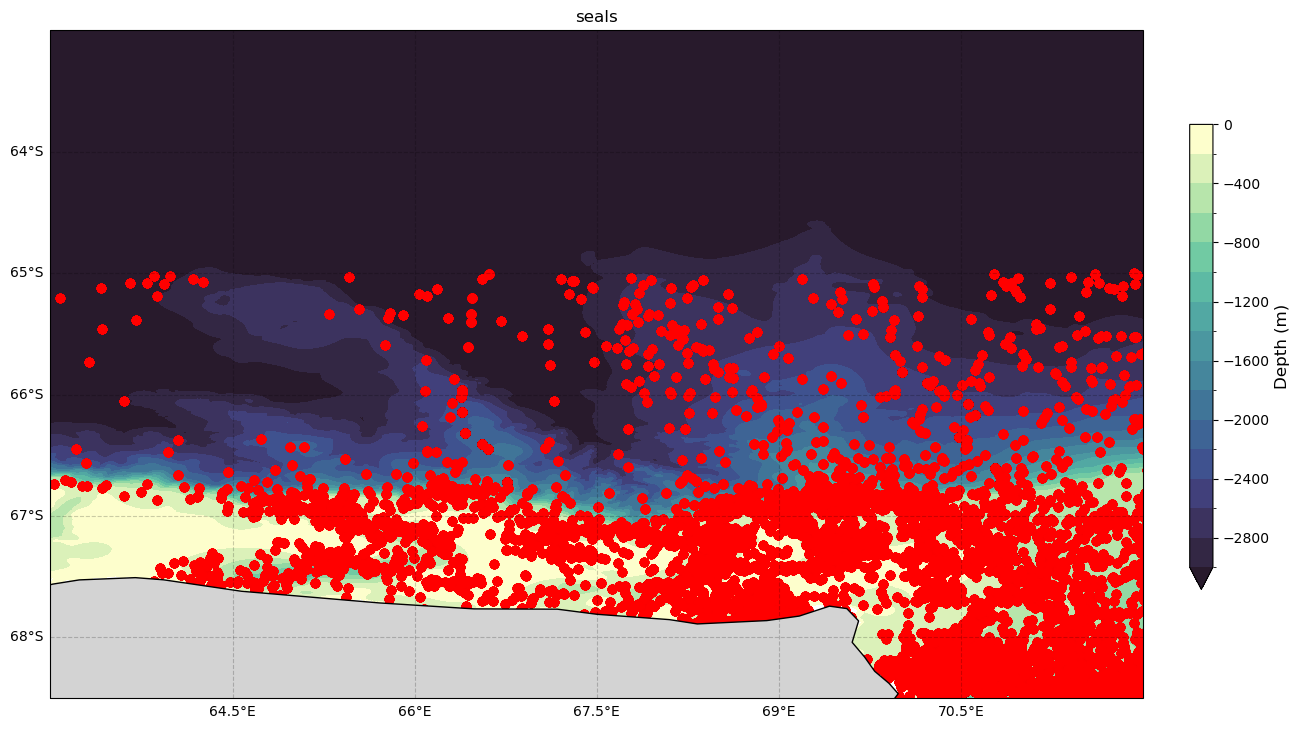

In [435]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(seals_longitude, seals_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('seals')

plt.show()

<Figure size 640x480 with 0 Axes>

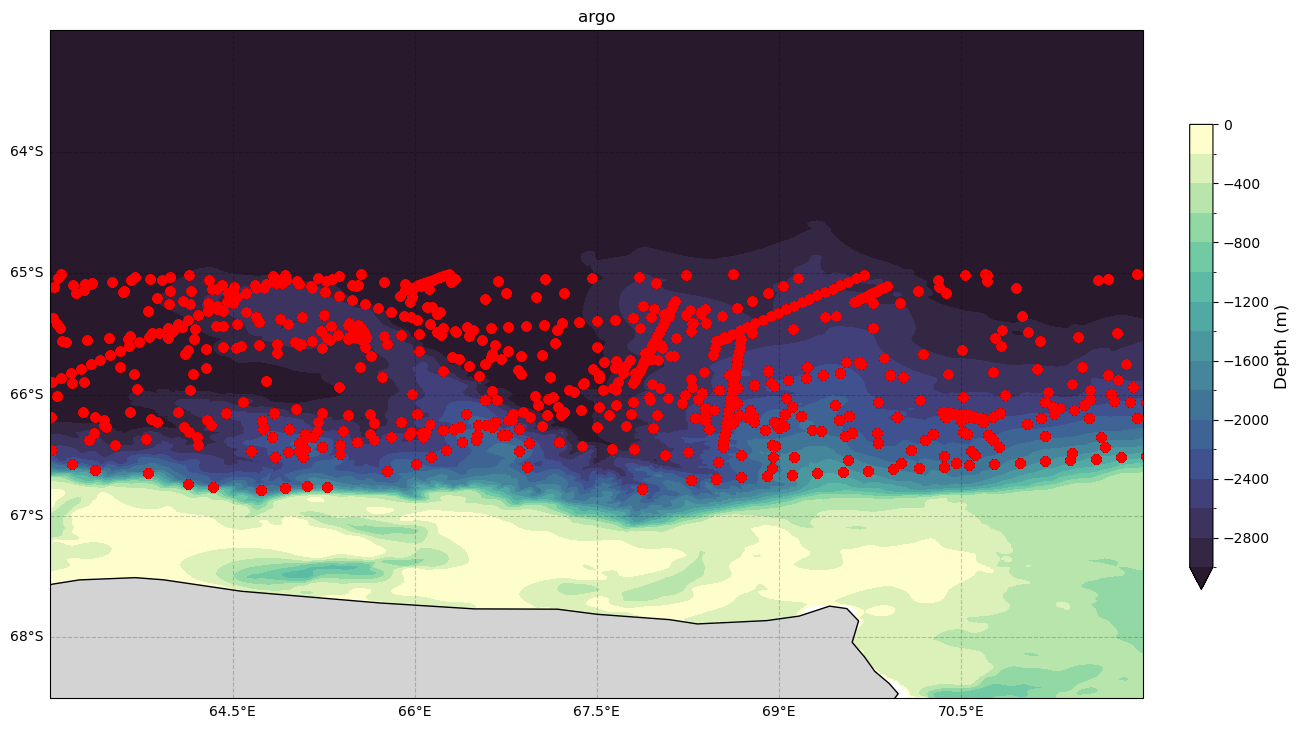

In [436]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(argo_longitude, argo_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('argo')

plt.show()

<Figure size 640x480 with 0 Axes>

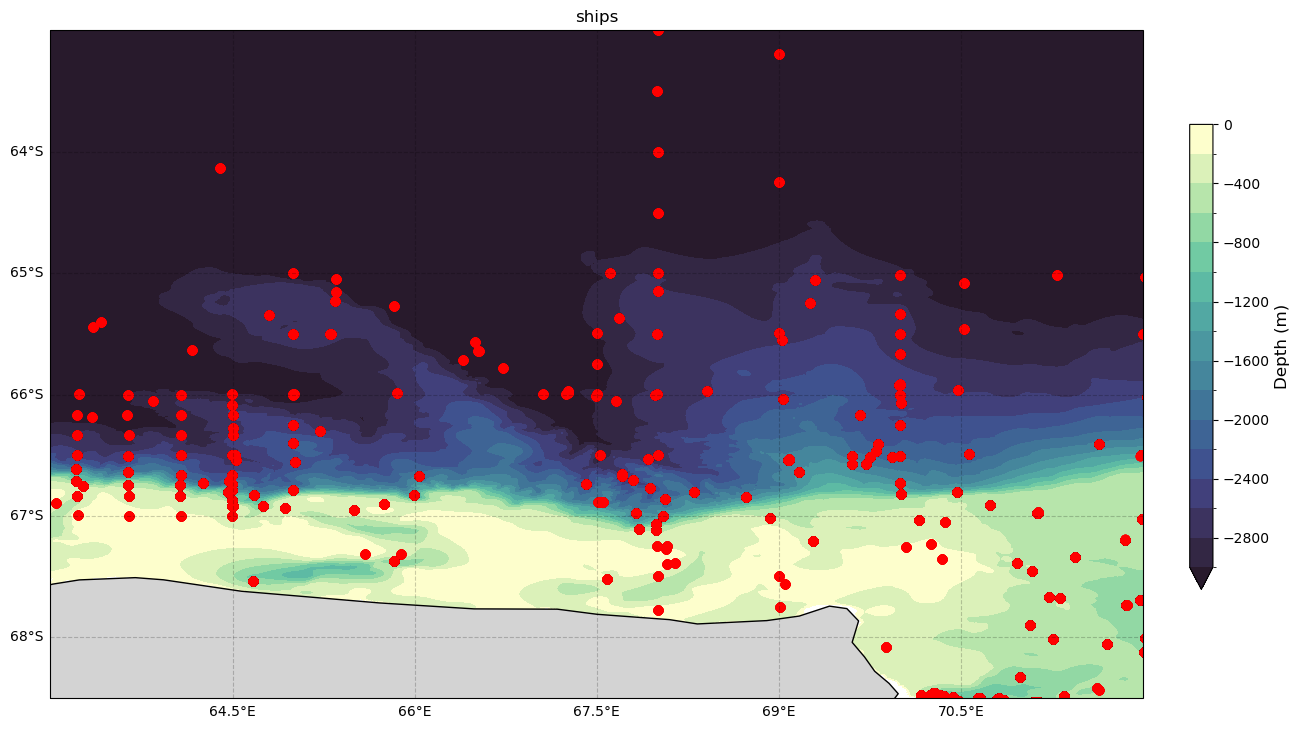

In [437]:
#visualise where your data is

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco_full.elevation.where(gebco_full.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Plot the contour polygon
ax.scatter(ships_longitude, ships_latitude, color='red')

#add colourbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Depth (m)', fontsize=12)

plt.title('ships')

plt.show()

In [ ]:
########################################################################################################
########################################################################################################
######### creating nc file for all raw data #####################
########################################################################################################
########################################################################################################

In [490]:
# Create a new NetCDF file
nc_filename = 'raw_data_all_variables.nc'
nc_file = nc.Dataset(nc_filename, 'w', format='NETCDF4')

# Define dimensions
num_records = len(temperature)
nc_file.createDimension('num_records', num_records)

# Create variables
temp_var = nc_file.createVariable('temperature', 'f4', ('num_records',))
cons_temp_var = nc_file.createVariable('cons_temperature', 'f4', ('num_records',))
salinity_var = nc_file.createVariable('salinity', 'f4', ('num_records',))
abs_salinity_var = nc_file.createVariable('abs_salinity', 'f4', ('num_records',))
oxygen_var = nc_file.createVariable('oxygen', 'f4', ('num_records',))
latitude_var = nc_file.createVariable('latitude', 'f4', ('num_records',))
longitude_var = nc_file.createVariable('longitude', 'f4', ('num_records',))
pressure_var = nc_file.createVariable('pressure', 'f4', ('num_records',))
depth_var = nc_file.createVariable('depth', 'f4', ('num_records',))
neutral_density_var = nc_file.createVariable('neutral_density', 'f4', ('num_records',))
time_var = nc_file.createVariable('time', 'f4', ('num_records',))
type_var = nc_file.createVariable('type', 'S1', ('num_records',))

# Assign values to variables
temp_var[:] = temperature
cons_temp_var[:] = cons_temperature
salinity_var[:] = salinity
abs_salinity_var[:] = abs_salinity
oxygen_var[:] = oxygen
latitude_var[:] = latitude
longitude_var[:] = longitude
pressure_var[:] = pressure
depth_var[:] = depth
neutral_density_var[:] = neutral_density
time_var[:] = time
type_var[:] = type.astype('S1')

# Close the NetCDF file
nc_file.close()

In [491]:
# load single ROMS netcdf with xr
ds_raw = xr.open_dataset('raw_data_all_variables.nc')
ds_raw

<xarray.Dataset>
Dimensions:           (num_records: 1491572)
Dimensions without coordinates: num_records
Data variables:
    temperature       (num_records) float32 ...
    cons_temperature  (num_records) float32 ...
    salinity          (num_records) float32 ...
    abs_salinity      (num_records) float32 ...
    oxygen            (num_records) float32 ...
    latitude          (num_records) float32 ...
    longitude         (num_records) float32 ...
    pressure          (num_records) float32 ...
    depth             (num_records) float32 ...
    neutral_density   (num_records) float32 ...
    time              (num_records) float32 ...
    type              (num_records) |S1 ...

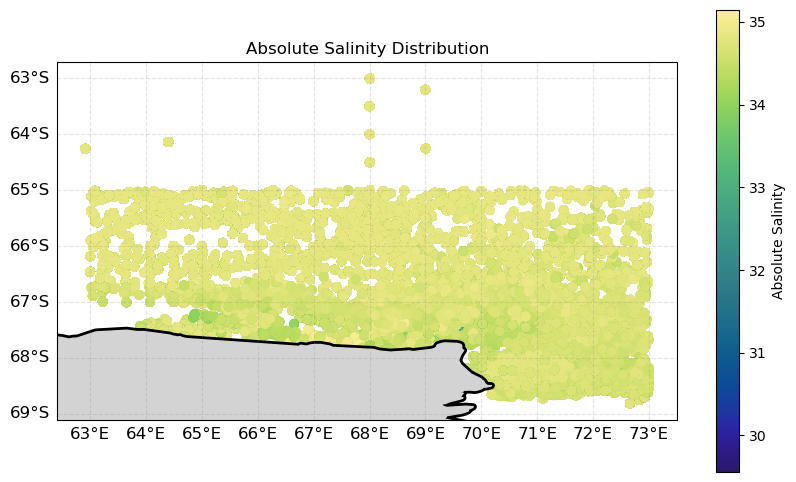

In [492]:
# Plot lat vs long colored by mean_abs_salinity
plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
# ax.set_extent([63, 72, -68.5, -64.9], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 74, 1), ylocs=np.arange(-69, -62, 1))
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 12}  # Adjust the size of the x-axis labels
gl.ylabel_style = {'size': 12}  # Adjust the size of the y-axis labels


scatter = plt.scatter(ds_raw.longitude, ds_raw.latitude, c=ds_raw.abs_salinity, cmap=cmap_salt)
plt.colorbar(scatter, label='Absolute Salinity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Absolute Salinity Distribution')
plt.grid(True)
plt.show()

In [438]:
########################################################################################################
########################################################################################################
######### creating nc file for all variables mean at each depth for unique lat lon #####################
########################################################################################################
########################################################################################################

In [470]:
# max depth of dataset is 4184m
# Define depth ranges
depth_ranges = [(0, 25)]  # Depth range for the first layer
depth_ranges += [(25 + i * 50, 75 + i * 50) for i in range(20)]  # Depth ranges from 50m to 1025m in 50m increments
depth_ranges += [(1050 + i * 100, 1150 + i * 100) for i in range(32)]  # Depth ranges from 1050m to 4300mm in 50m increments

print(depth_ranges)

[(0, 25), (25, 75), (75, 125), (125, 175), (175, 225), (225, 275), (275, 325), (325, 375), (375, 425), (425, 475), (475, 525), (525, 575), (575, 625), (625, 675), (675, 725), (725, 775), (775, 825), (825, 875), (875, 925), (925, 975), (975, 1025), (1050, 1150), (1150, 1250), (1250, 1350), (1350, 1450), (1450, 1550), (1550, 1650), (1650, 1750), (1750, 1850), (1850, 1950), (1950, 2050), (2050, 2150), (2150, 2250), (2250, 2350), (2350, 2450), (2450, 2550), (2550, 2650), (2650, 2750), (2750, 2850), (2850, 2950), (2950, 3050), (3050, 3150), (3150, 3250), (3250, 3350), (3350, 3450), (3450, 3550), (3550, 3650), (3650, 3750), (3750, 3850), (3850, 3950), (3950, 4050), (4050, 4150), (4150, 4250)]


In [471]:
# Initialize an empty DataFrame to store the mean data
mean_data = pd.DataFrame()

# Loop through depth ranges
for depth_range in depth_ranges:
    # Calculate the depth midpoint
    depth_midpoint = np.mean(depth_range)
    
    # Filter data based on depth range
    criteria_indices = np.where(np.logical_and(depth_range[0] < depth, depth < depth_range[1]))
    
    # Create a DataFrame with the filtered data
    filtered_data = pd.DataFrame({
        'latitude': latitude[criteria_indices],
        'longitude': longitude[criteria_indices],
        'depth': depth[criteria_indices],
        'absolute salinity': abs_salinity[criteria_indices],
        'conservative temperature': cons_temperature[criteria_indices],
        'oxygen': oxygen[criteria_indices],
        'neutral density': neutral_density[criteria_indices]
    })
    
    # Replace oxygen values below 150 with NaN
    filtered_data.loc[filtered_data['oxygen'] < 150, 'oxygen'] = np.nan
       

    # Group the data by unique latitude and longitude and calculate mean values
    grouped = filtered_data.groupby(['latitude', 'longitude'])
    mean_abs_salinity = grouped['absolute salinity'].mean().reset_index(name='mean_abs_salinity')
    mean_cons_temperature = grouped['conservative temperature'].mean().reset_index(name='mean_cons_temperature')
    mean_oxygen = grouped['oxygen'].mean().reset_index(name='mean_oxygen')
    mean_neutral_density = grouped['neutral density'].mean().reset_index(name='mean_neutral_density')
    
    # Merge mean dataframes on latitude and longitude
    mean_depth_data = pd.merge(mean_abs_salinity, mean_cons_temperature, on=['latitude', 'longitude'])
    mean_depth_data = pd.merge(mean_depth_data, mean_oxygen, on=['latitude', 'longitude'])
    mean_depth_data = pd.merge(mean_depth_data, mean_neutral_density, on=['latitude', 'longitude'])

    # Add depth column with constant value representing midpoint of the depth range
    mean_depth_data['depth'] = depth_midpoint

    # Append mean data for this depth range to the overall mean_data DataFrame
    mean_data = pd.concat([mean_data, mean_depth_data], ignore_index=True)


# Print the resulting mean data
mean_data

,latitude,longitude,mean_abs_salinity,mean_cons_temperature,mean_oxygen,mean_neutral_density,depth
0,-68.814330,72.65833,33.083865,0.128915,NaN,26.471174,12.5
1,-68.753334,72.83500,34.412561,-0.728980,NaN,27.770167,12.5
2,-68.725000,71.10000,34.412460,-1.533531,NaN,27.809069,12.5
3,-68.708700,72.90170,33.604022,-0.626530,358.033508,27.004587,12.5
4,-68.702700,72.92270,33.448276,-1.818892,409.463409,26.901672,12.5
...,...,...,...,...,...,...,...
94686,-63.000500,68.00233,34.868868,-0.322642,NaN,28.368430,3800.0
94687,-63.000500,68.00233,34.869039,-0.359772,NaN,28.376310,3900.0
94688,-63.000500,68.00233,34.869169,-0.398331,NaN,28.384492,4000.0
94689,-63.000500,68.00233,34.867852,-0.441280,NaN,28.392234,4100.0


In [473]:
xr.Dataset(mean_data.to_xarray()).to_netcdf('mean_data_points.nc')

In [474]:
# load single ROMS netcdf with xr
ds = xr.open_dataset('mean_data_points.nc')
ds

# Get unique depth values
unique_depths = np.unique(ds.depth.values)

# Print unique depth values
print("Unique Depth Values:")
print(unique_depths)

Unique Depth Values:
[  12.5   50.   100.   150.   200.   250.   300.   350.   400.   450.
  500.   550.   600.   650.   700.   750.   800.   850.   900.   950.
 1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
 2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
 3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
 4000.  4100.  4200. ]


In [475]:
chosen_depth = 300

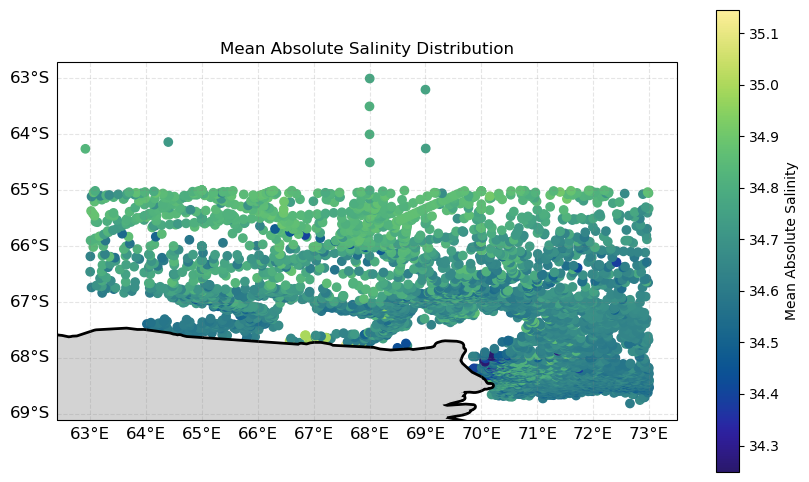

In [476]:
# Filter data to depth of choice
data_at_depth = ds.where(ds.depth == chosen_depth, drop=True)

# Plot lat vs long colored by mean_abs_salinity
plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
# ax.set_extent([63, 72, -68.5, -64.9], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 74, 1), ylocs=np.arange(-69, -62, 1))
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 12}  # Adjust the size of the x-axis labels
gl.ylabel_style = {'size': 12}  # Adjust the size of the y-axis labels


scatter = plt.scatter(data_at_depth.longitude, data_at_depth.latitude, c=data_at_depth.mean_abs_salinity, cmap=cmap_salt)
plt.colorbar(scatter, label='Mean Absolute Salinity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean Absolute Salinity Distribution')
plt.grid(True)
plt.show()

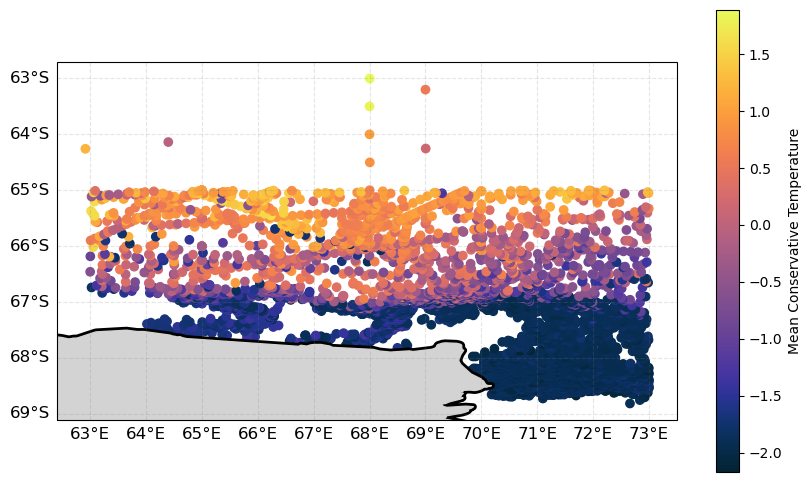

In [477]:
# Filter data to depth of choice
data_at_depth = ds.where(ds.depth == chosen_depth, drop=True)

# Plot lat vs long colored by mean_abs_salinity
plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
# ax.set_extent([63, 72, -68.5, -64.9], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 74, 1), ylocs=np.arange(-69, -62, 1))
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 12}  # Adjust the size of the x-axis labels
gl.ylabel_style = {'size': 12}  # Adjust the size of the y-axis labels


scatter = plt.scatter(data_at_depth.longitude, data_at_depth.latitude, c=data_at_depth.mean_cons_temperature, cmap=cmap_temp)
plt.colorbar(scatter, label='Mean Conservative Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

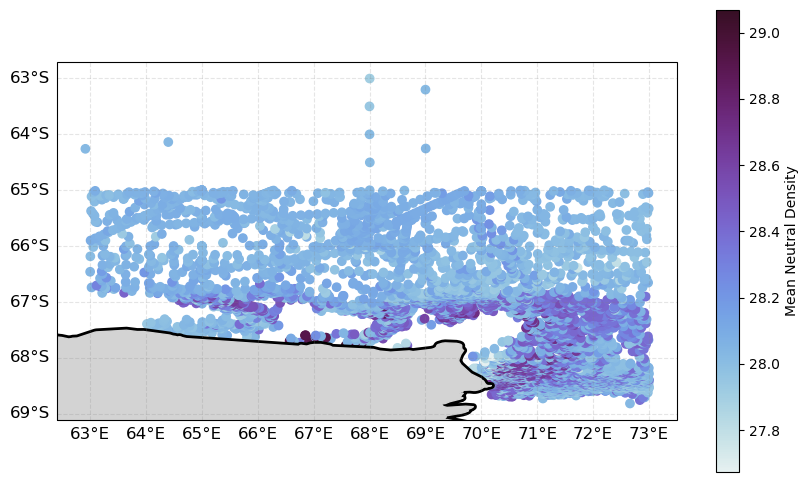

In [478]:
# Filter data to depth of choice
data_at_depth = ds.where(ds.depth == chosen_depth, drop=True)

# Plot lat vs long colored by mean_abs_salinity
plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
# ax.set_extent([63, 72, -68.5, -64.9], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 74, 1), ylocs=np.arange(-69, -62, 1))
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 12}  # Adjust the size of the x-axis labels
gl.ylabel_style = {'size': 12}  # Adjust the size of the y-axis labels




scatter = plt.scatter(data_at_depth.longitude, data_at_depth.latitude, c=data_at_depth.mean_neutral_density, cmap=cmap_dens)
plt.colorbar(scatter, label='Mean Neutral Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

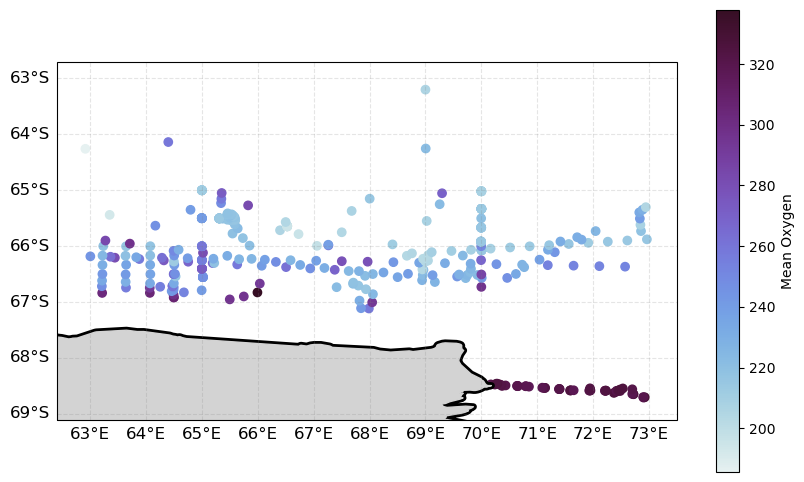

In [479]:
# Filter data to depth of choice
data_at_depth = ds.where(ds.depth == chosen_depth, drop=True)

# Plot lat vs long colored by mean_abs_salinity
plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=5)
ax.add_feature(land)
# ax.set_extent([63, 72, -68.5, -64.9], crs=ccrs.PlateCarree())
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.2, linestyle='--', xlocs=np.arange(63, 74, 1), ylocs=np.arange(-69, -62, 1))
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 12}  # Adjust the size of the x-axis labels
gl.ylabel_style = {'size': 12}  # Adjust the size of the y-axis labels


scatter = plt.scatter(data_at_depth.longitude, data_at_depth.latitude, c=data_at_depth.mean_oxygen, cmap=cmap_dens)
plt.colorbar(scatter, label='Mean Oxygen')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [ ]:
########################################################################################################
########################################################################################################
################### creating nc file for all variables mean at as gridded data #########################
########################################################################################################
########################################################################################################

In [480]:
mean_data

,latitude,longitude,mean_abs_salinity,mean_cons_temperature,mean_oxygen,mean_neutral_density,depth
0,-68.814330,72.65833,33.083865,0.128915,NaN,26.471174,12.5
1,-68.753334,72.83500,34.412561,-0.728980,NaN,27.770167,12.5
2,-68.725000,71.10000,34.412460,-1.533531,NaN,27.809069,12.5
3,-68.708700,72.90170,33.604022,-0.626530,358.033508,27.004587,12.5
4,-68.702700,72.92270,33.448276,-1.818892,409.463409,26.901672,12.5
...,...,...,...,...,...,...,...
94686,-63.000500,68.00233,34.868868,-0.322642,NaN,28.368430,3800.0
94687,-63.000500,68.00233,34.869039,-0.359772,NaN,28.376310,3900.0
94688,-63.000500,68.00233,34.869169,-0.398331,NaN,28.384492,4000.0
94689,-63.000500,68.00233,34.867852,-0.441280,NaN,28.392234,4100.0


In [481]:
# Define the grid resolution and the range of latitudes and longitudes you want to cover
lat_resolution = 0.1
lon_resolution = 0.1

min_lat = -69
max_lat = -63
min_lon = 63
max_lon = 73

# Get unique depth values from mean_data
depth_values = mean_data['depth'].unique()

print(depth_values)

[  12.5   50.   100.   150.   200.   250.   300.   350.   400.   450.
  500.   550.   600.   650.   700.   750.   800.   850.   900.   950.
 1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
 2000.  2100.  2200.  2300.  2400.  2500.  2600.  2700.  2800.  2900.
 3000.  3100.  3200.  3300.  3400.  3500.  3600.  3700.  3800.  3900.
 4000.  4100.  4200. ]


In [483]:
# Create a dictionary to store mean grids for each parameter
mean_grids = {}

# List of parameters to include in the NetCDF file
parameters = ['mean_abs_salinity', 'mean_cons_temperature', 'mean_oxygen', 'mean_neutral_density']

# Iterate through each parameter
for parameter in parameters:
    mean_grids[parameter] = {}  # Create a sub-dictionary for each parameter
    
    # Iterate through each unique depth value
    for depth in depth_values:
        # Filter data for the current depth
        data = mean_data[mean_data['depth'] == depth]

        # Create empty grids for latitude, longitude, and parameter totals
        total_grid = np.zeros((len(latitudes), len(longitudes)))
        count_grid = np.zeros((len(latitudes), len(longitudes)))

        # Iterate through each data point and accumulate the parameter values into the corresponding grid cell
        for index, row in data.iterrows():
            lat = row['latitude']
            lon = row['longitude']
            value = row[parameter]

            lat_index = int((lat - min_lat) / lat_resolution)
            lon_index = int((lon - min_lon) / lon_resolution)

            total_grid[lat_index, lon_index] += value
            count_grid[lat_index, lon_index] += 1

        # Replace zero values in total_grid with NaN where count is zero
        total_grid[count_grid == 0] = np.nan

        # Divide total_grid by count_grid to calculate the mean
        mean_grid = np.divide(total_grid, count_grid)

        # Store the mean grid for the current depth and parameter
        mean_grids[parameter][depth] = mean_grid

# Define the output NetCDF file path
output_file = "mean_data_grids.nc"

# Create a new NetCDF file
with nc.Dataset(output_file, "w") as rootgrp:
    # Define dimensions for latitude, longitude, and depth
    rootgrp.createDimension("latitude", len(latitudes))
    rootgrp.createDimension("longitude", len(longitudes))
    rootgrp.createDimension("depth", len(depth_values))

    # Create variables for latitude, longitude, and depth
    latitudes_var = rootgrp.createVariable("latitude", "f4", ("latitude",))
    longitudes_var = rootgrp.createVariable("longitude", "f4", ("longitude",))
    depths_var = rootgrp.createVariable("depth", "f4", ("depth",))

    # Assign values to latitude, longitude, and depth variables
    latitudes_var[:] = latitudes
    longitudes_var[:] = longitudes
    depths_var[:] = depth_values

    # Create variables to store mean grids for each parameter
    for parameter in parameters:
        parameter_var = rootgrp.createVariable(parameter, "f4", ("depth", "latitude", "longitude",))
        
        # Assign mean grids to the variable
        for i, depth in enumerate(depth_values):
            parameter_var[i, :, :] = mean_grids[parameter][depth]

        # Add metadata
        parameter_var.units = "unit"  # You can replace "unit" with appropriate units for each parameter

print("NetCDF file saved successfully.")


NetCDF file saved successfully.


In [484]:
# load single ROMS netcdf with xr
ds_grid = xr.open_dataset('mean_data_grids.nc')
ds_grid

<xarray.Dataset>
Dimensions:                (latitude: 62, longitude: 101, depth: 53)
Coordinates:
  * latitude               (latitude) float32 -69.0 -68.9 -68.8 ... -63.0 -62.9
  * longitude              (longitude) float32 63.0 63.1 63.2 ... 72.8 72.9 73.0
  * depth                  (depth) float32 12.5 50.0 100.0 ... 4.1e+03 4.2e+03
Data variables:
    mean_abs_salinity      (depth, latitude, longitude) float32 ...
    mean_cons_temperature  (depth, latitude, longitude) float32 ...
    mean_oxygen            (depth, latitude, longitude) float32 ...
    mean_neutral_density   (depth, latitude, longitude) float32 ...

In [485]:
# Test you can open and use the nc file
# Extract mean salinity grid at 100m depth
depth_chosen = 150  # Depth in meters

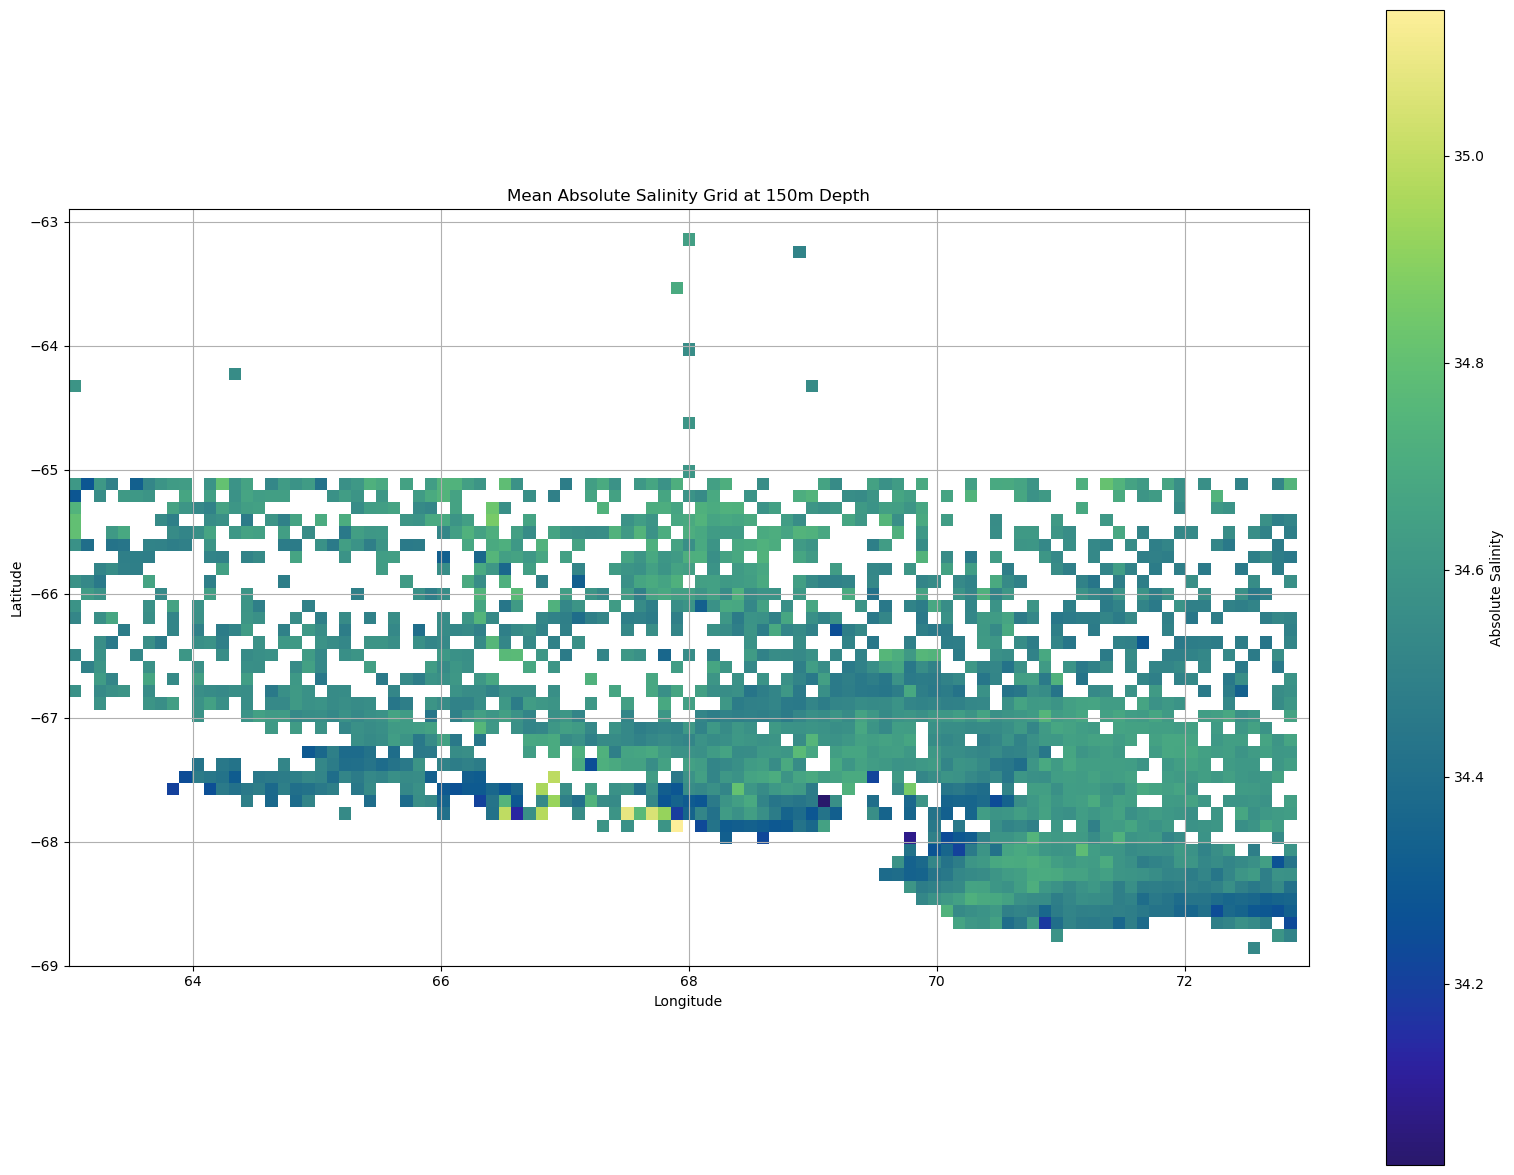

In [486]:
mean_grid = ds_grid['mean_abs_salinity'].sel(depth=depth_chosen)

# Get longitude and latitude values
lon = ds_grid['longitude'].values
lat = ds_grid['latitude'].values

# Plotting the mean_salinity_grid at 100m depth
plt.figure(figsize=(20, 15))
plt.imshow(mean_grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()], origin='lower', cmap=cmap_salt)
plt.colorbar(label='Absolute Salinity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mean Absolute Salinity Grid at {depth_chosen}m Depth')
plt.grid(True)
plt.show()


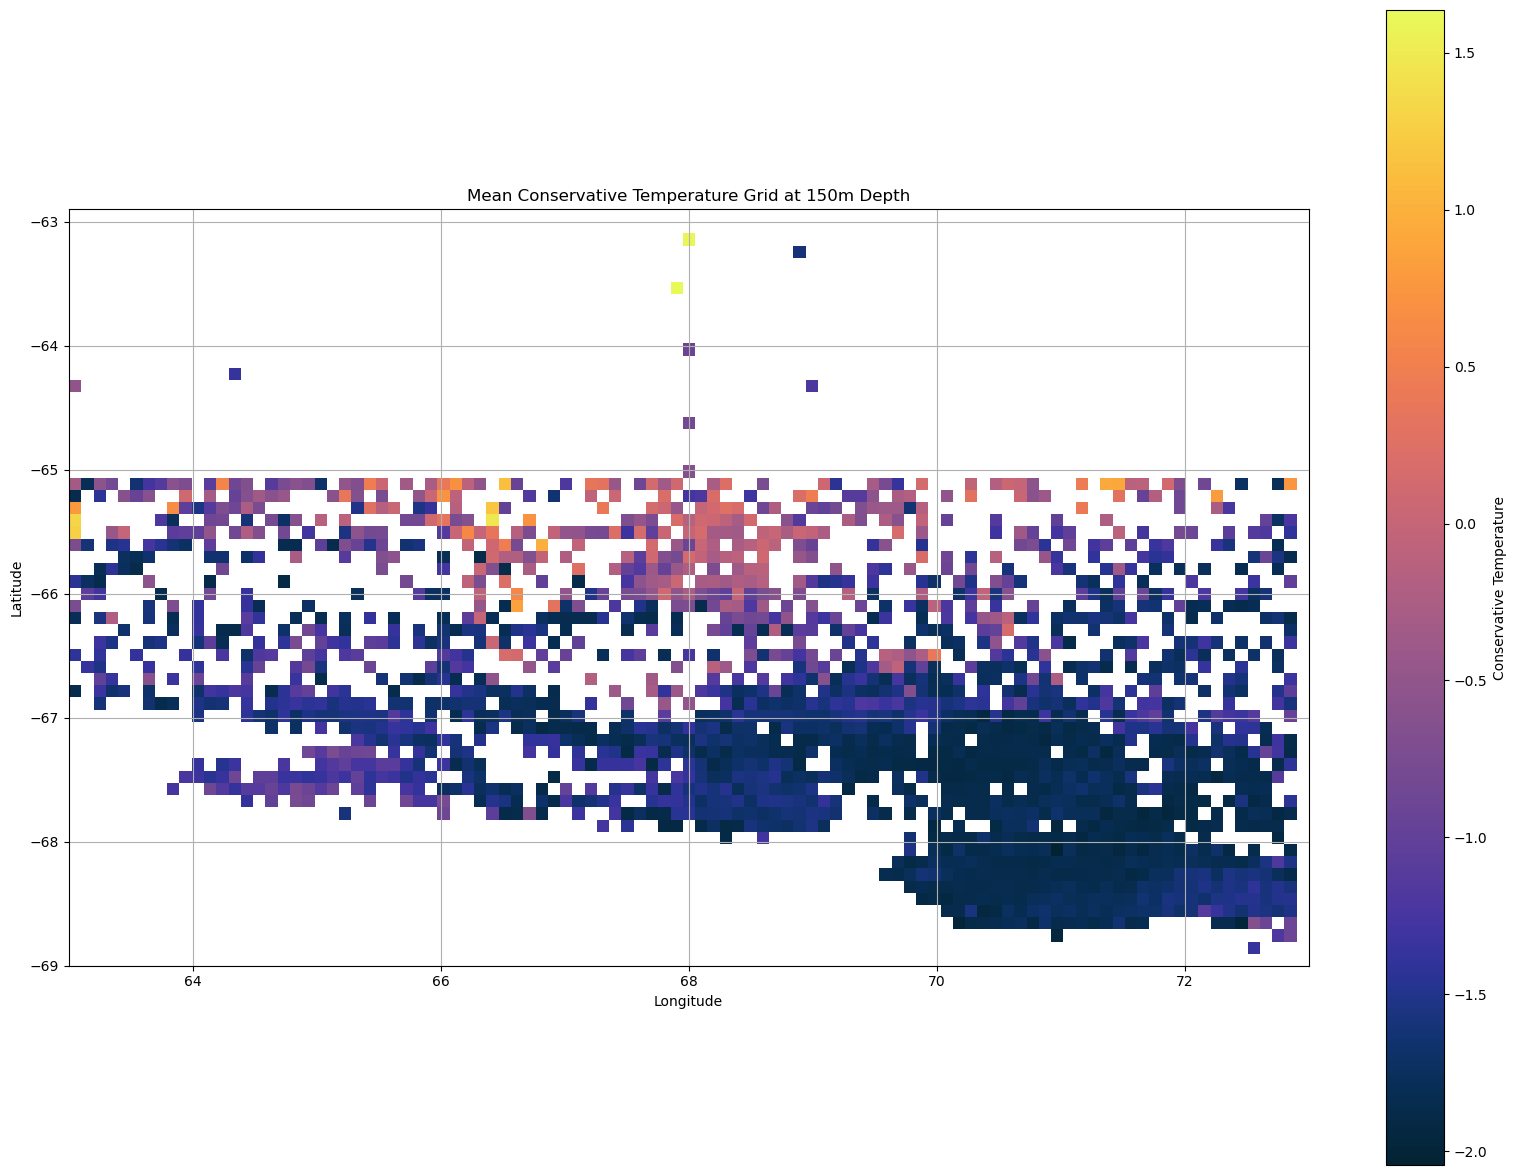

In [487]:
mean_grid = ds_grid['mean_cons_temperature'].sel(depth=depth_chosen)

# Get longitude and latitude values
lon = ds_grid['longitude'].values
lat = ds_grid['latitude'].values

# Plotting the mean_salinity_grid at 100m depth
plt.figure(figsize=(20, 15))
plt.imshow(mean_grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()], origin='lower', cmap=cmap_temp)
plt.colorbar(label='Conservative Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mean Conservative Temperature Grid at {depth_chosen}m Depth')
plt.grid(True)
plt.show()


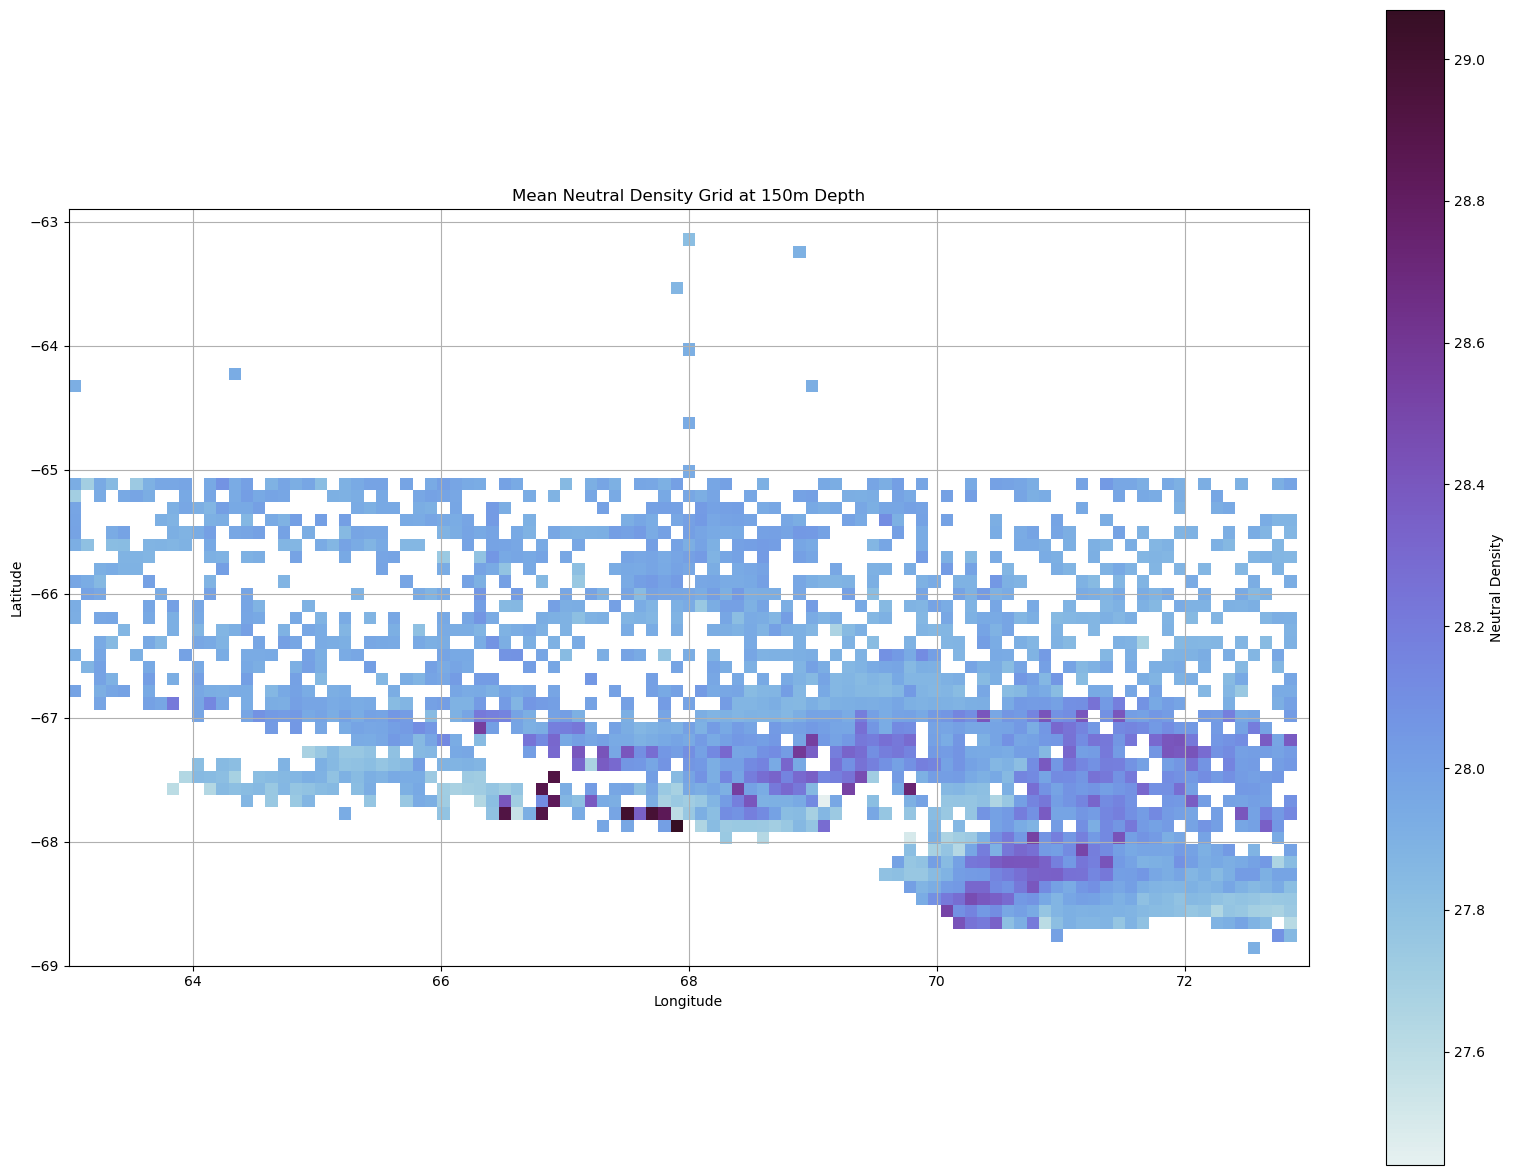

In [488]:
mean_grid = ds_grid['mean_neutral_density'].sel(depth=depth_chosen)

# Get longitude and latitude values
lon = ds_grid['longitude'].values
lat = ds_grid['latitude'].values

# Plotting the mean_salinity_grid at 100m depth
plt.figure(figsize=(20, 15))
plt.imshow(mean_grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()], origin='lower', cmap=cmap_dens)
plt.colorbar(label='Neutral Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mean Neutral Density Grid at {depth_chosen}m Depth')
plt.grid(True)
plt.show()


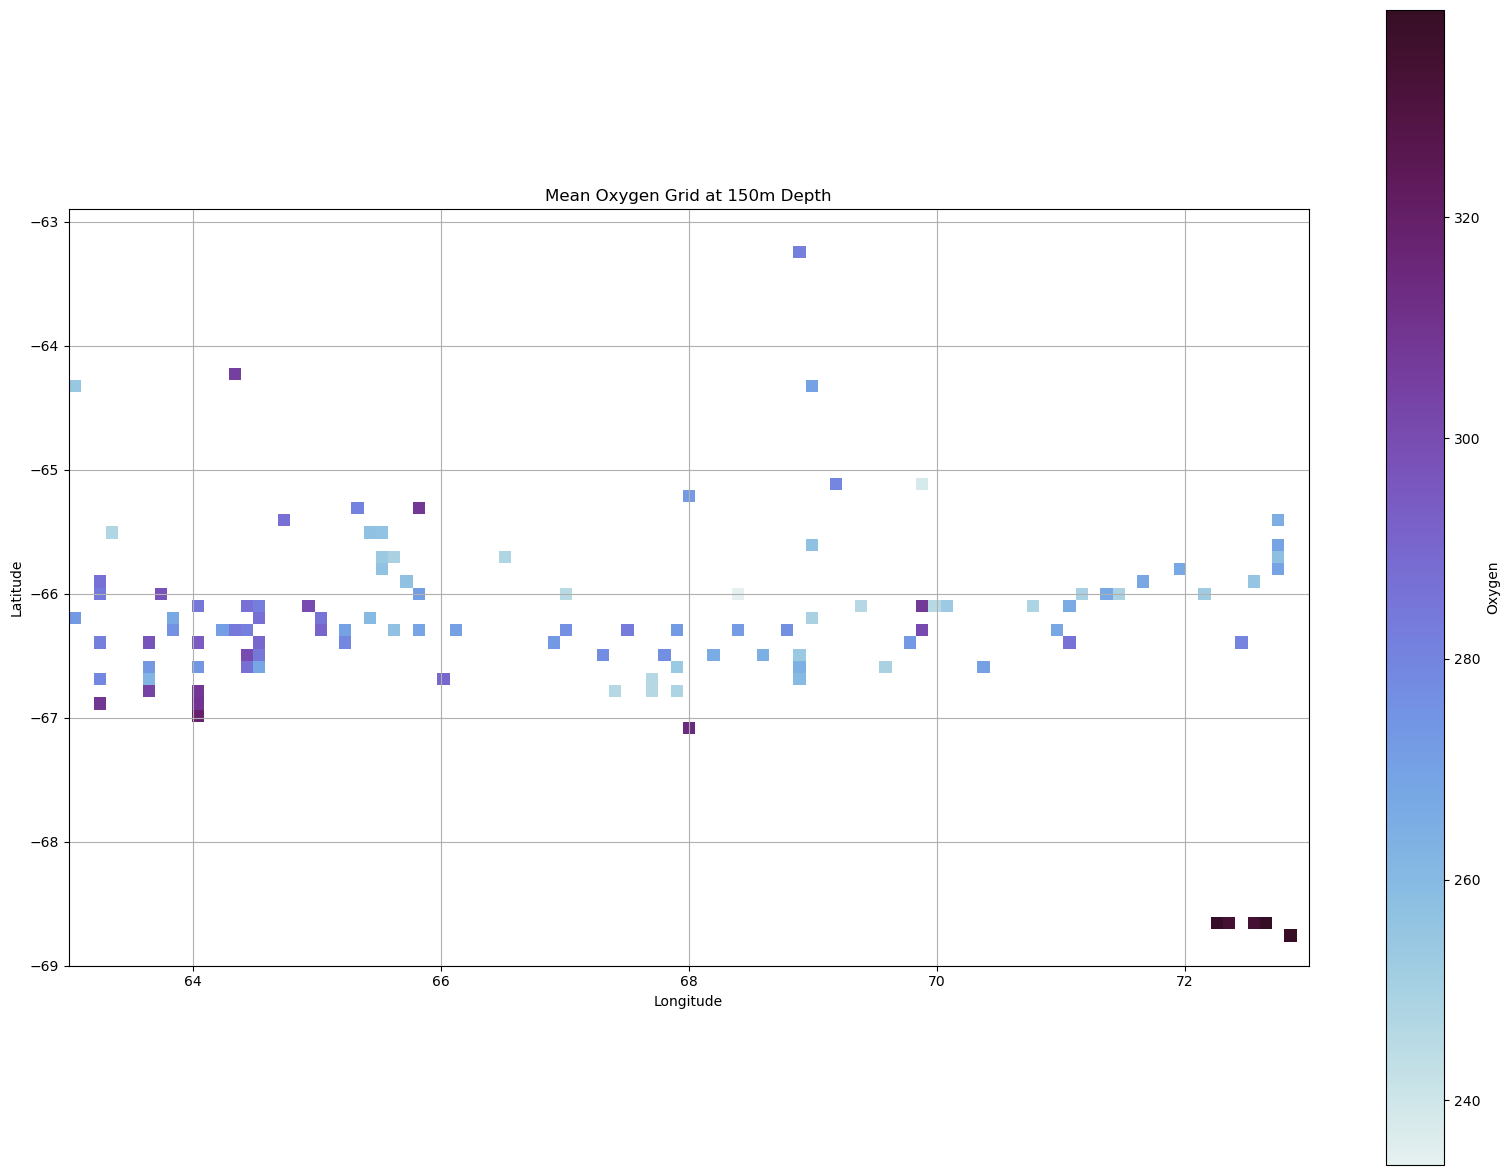

In [489]:
mean_grid = ds_grid['mean_oxygen'].sel(depth=depth_chosen)

# Get longitude and latitude values
lon = ds_grid['longitude'].values
lat = ds_grid['latitude'].values

# Plotting the mean_salinity_grid at 100m depth
plt.figure(figsize=(20, 15))
plt.imshow(mean_grid, extent=[lon.min(), lon.max(), lat.min(), lat.max()], origin='lower', cmap=cmap_dens)
plt.colorbar(label='Oxygen')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mean Oxygen Grid at {depth_chosen}m Depth')
plt.grid(True)
plt.show()
